In [ ]:
from pathlib import Path

import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.io import decode_image

from torchvision import models

In [ ]:
class cats_dogs(Dataset):
  def __init__(self, folder, transform=None):
    cats = sorted((folder / "cats").glob("*.jpg"))
    dogs = sorted((folder / "dogs").glob("*.jpg"))
    self.fpaths = cats + dogs
    self.labels = [int(f.stem.startswith("dog")) for f in self.fpaths] # dog=1 & cat=0
    self.transform = transform

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, idx):
    label = self.labels[idx]
    image = decode_image(self.fpaths[idx])
    if self.transform:
      image = self.transform(image)
    return image, label

In [ ]:
@torch.inference_mode()
def accuracy(x, y, model):
    prediction = F.sigmoid(model(x).squeeze())
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
path = kagglehub.dataset_download("tongpython/cat-and-dog")
path

'C:\\Users\\user\\.cache\\kagglehub\\datasets\\tongpython\\cat-and-dog\\versions\\1'

In [ ]:
dataroot = Path(path)
train_data_dir = dataroot / "training_set" / "training_set"
test_data_dir = dataroot / "test_set" / "test_set"

In [ ]:
weights = models.VGG16_Weights.DEFAULT

In [ ]:
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
model = models.vgg16(weights=weights)
for param in model.parameters(): 
    param.requires_grad = False
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))  # (batch_size, 512, 1, 1)
model.classifier = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(512, 128), 
    nn.ReLU(), 
    nn.Dropout(0.2), 
    nn.Linear(128, 1), 
)  # (batch_size, 1)
model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1]                    --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

In [ ]:
train_dataset = cats_dogs(train_data_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataset = cats_dogs(test_data_dir, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
loss_fn = nn.BCEWithLogitsLoss()

optimizer = Adam(model.parameters(), lr=1e-5)

num_epochs = 5

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_epoch_accuracies = []

    train_loader = tqdm(train_dataloader)
    train_loader.set_description(f"Train {epoch}")
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.float().to(device)
        y_pred = model(x).squeeze()

        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loader.set_postfix(loss=loss.item())
        train_loss += loss.item()

        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    train_accuracies.append(train_epoch_accuracy)
    print(f"Train loss: {train_loss:.4f} - Train accuracy: {train_epoch_accuracy:.4f}")

    with torch.inference_mode():
        model.eval()
        val_loss = 0
        val_epoch_accuracies = []

        val_loader = tqdm(val_dataloader)
        val_loader.set_description(f"Val   {epoch}")
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.float().to(device)
            y_pred = model(x).squeeze()

            loss = loss_fn(y_pred, y)

            val_loss += loss.item()

            is_correct = accuracy(x, y, model)
            val_epoch_accuracies.extend(is_correct)
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
        val_epoch_accuracy = np.mean(val_epoch_accuracies)
        val_accuracies.append(val_epoch_accuracy)
        print(f"Val loss: {val_loss:.4f} - Val accuracy: {val_epoch_accuracy:.4f}")
    print()

Train 0: 100%|██████████| 250/250 [00:43<00:00,  5.75it/s, loss=0.552]


Train loss: 0.6399 - Train accuracy: 0.7501


Val   0: 100%|██████████| 64/64 [00:10<00:00,  5.87it/s]


Val loss: 0.5728 - Val accuracy: 0.9219



Train 1: 100%|██████████| 250/250 [00:42<00:00,  5.95it/s, loss=0.436]


Train loss: 0.5075 - Train accuracy: 0.9483


Val   1: 100%|██████████| 64/64 [00:10<00:00,  6.28it/s]


Val loss: 0.4435 - Val accuracy: 0.9684



Train 2: 100%|██████████| 250/250 [00:53<00:00,  4.64it/s, loss=0.341]


Train loss: 0.3903 - Train accuracy: 0.9683


Val   2: 100%|██████████| 64/64 [00:12<00:00,  5.21it/s]


Val loss: 0.3407 - Val accuracy: 0.9787



Train 3: 100%|██████████| 250/250 [00:49<00:00,  5.04it/s, loss=0.287]


Train loss: 0.3034 - Train accuracy: 0.9751


Val   3: 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]


Val loss: 0.2668 - Val accuracy: 0.9822



Train 4: 100%|██████████| 250/250 [00:50<00:00,  4.99it/s, loss=0.188]


Train loss: 0.2407 - Train accuracy: 0.9779


Val   4: 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]

Val loss: 0.2140 - Val accuracy: 0.9837



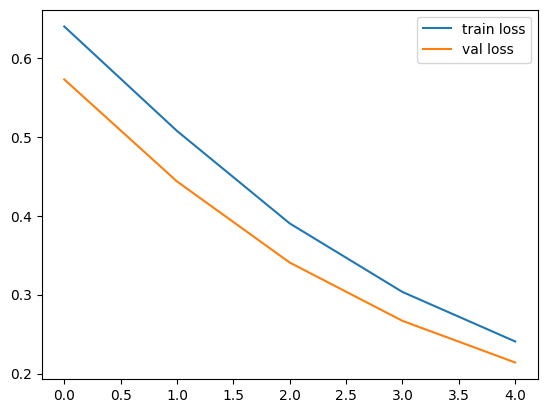

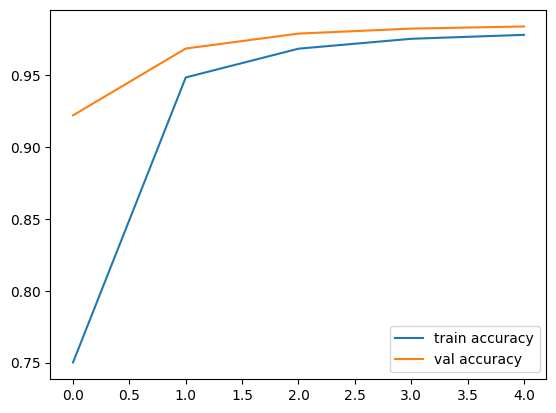

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label="train accuracy")
plt.plot(val_accuracies, label="val accuracy")
plt.legend()
plt.show()